In [7]:
# Stock Downloader Yahoo In-Memory / Python 3
def YahooStocks(tickers = ["MSFT", "FB"], freq = "d", selectColumn = "AdjClose", fromDate = None, toDate = None):
    
    """
    NOTES:
    tickers = Defaults to ["MSFT","FB"], and uses a list as input
    freq = Defaults to "d" (Note: Can be "d"[daily],"m"[monthly],"q"[quarterly], or "v"[dividends])
    selectColumn = Defaults to "AdjClose". Can choose between "Open", "High", "Low", "Close", "Volume" or "AdjClose".
    fromDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.
    toDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.
    
    """
    import pandas as pd
    import datetime
    # For downloader
    import urllib.request
    import io
    import urllib.error
    
    stackData = pd.DataFrame()
    fullData = pd.DataFrame()
    fullDataClean = pd.DataFrame()
    
    for ticker in tickers:
        
        data = pd.DataFrame() 
        fromDateInternal = pd.DataFrame() 
        toDateInternal = pd.DataFrame()
        tickersNarrow = pd.DataFrame()

        url = []
        xld = []
        xlds = []


        if fromDate is None:

            toDateInternal = datetime.datetime.now()
            fromDateInternal = toDateInternal - datetime.timedelta(days=360)

            toDateInternal  = str(toDateInternal.date())
            toDateInternal = toDateInternal.replace('-', '/')
            toDateInternal = pd.to_datetime(toDateInternal, format = "%Y/%m/%d").date()


            fromDateInternal  = str(fromDateInternal.date())
            fromDateInternal = fromDateInternal.replace('-', '/')
            fromDateInternal = pd.to_datetime(fromDateInternal, format = "%Y/%m/%d").date()

        else:
            

            fromDateInternal = fromDate
            fromDateInternal = fromDateInternal.replace('-', '/')
            fromDateInternal = datetime.datetime.strptime(fromDateInternal, "%Y/%m/%d").date()


            if toDate == None: 
                toDateInternal = str(datetime.datetime.now().date())
                toDateInternal = toDateInternal.replace('-', '/')
                toDateInternal = datetime.datetime.strptime(toDateInternal, "%Y/%m/%d").date()

            else:
                toDateInternal  = str(toDate)
                toDateInternal = toDateInternal.replace('-', '/')
                toDateInternal = datetime.datetime.strptime(toDateInternal, "%Y/%m/%d").date()

        #print(fromDateInternal)
        #print(toDateInternal)
        
        # Downloader
        url = "http://real-chart.finance.yahoo.com/table.csv?s=" + ticker + "&a=0" + str(fromDateInternal.month) + "&b=" + \
            str(fromDateInternal.day) + "&c=" + str(fromDateInternal.year) + "&d=0" + str(toDateInternal.month) + "&e="  +  \
                str(toDateInternal.day) + "&f=" +  str(toDateInternal.year) + "&g=" + freq + "&ignore=.csv"

        #Checks if 404 error from no data in ticker
        try:
            
            xld = urllib.request.urlopen(url).read()
            xld = xld.decode('utf-8')
            xlds = io.StringIO(xld)
            data = pd.read_csv(xlds, delimiter=',', header=None, skiprows=1)
            data.columns = ["Date", "Open", "High", "Low", "Close", "Volume", "AdjClose"]

            data['Date'] = pd.to_datetime(data['Date'], format = "%Y-%m-%d")
            data[["Open", "High", "Low", "Close", "Volume", "AdjClose"]] = data[["Open", "High", "Low", "Close", "Volume", "AdjClose"]].astype(float)
            data["Security"] = ticker

            stackData = pd.concat([stackData, data])
            
            print(ticker, ": ", url)

            
        except urllib.error.HTTPError as err:
            print(ticker, ": No data for ticker exists in the given date range")
            if err.code == 404:
                continue
            else:
                raise
                
    ## Find all dates and create index
    # Returns all dates among used ticker data
    uniqueDates = stackData.Date.map(lambda t: t.date()).unique()
    uniqueDates = pd.DataFrame(uniqueDates, columns = ['Date'] ).sort_values(by = "Date", ascending = [0])
    uniqueDates['Date'] = pd.to_datetime(uniqueDates['Date'], format = "%Y-%m-%d")

    fullData = uniqueDates
    
    tickersNarrow = stackData.Security.unique() # Find usable tickers
    
    ## Loop through each ticker
    for ticker in tickersNarrow:
        fullData = pd.merge(fullData, stackData[stackData.Security==ticker][['Date',selectColumn]], on = "Date", how = 'left')
        fullData.rename(columns={selectColumn:(ticker + "_" + selectColumn)}, inplace = True)
        
        
    # Drop any rows with NaN
    fullDataClean = fullData.dropna()
    
    print()
    print( "fullData Dates range from: ", min(fullData.Date).date(), " to ", max(fullData.Date).date() )
    print( "fullDataClean Dates range from: ", min(fullDataClean.Date).date(), " to ", max(fullDataClean.Date).date() )
    print()

    return fullData, fullDataClean, stackData


#     tickers = Defaults to ["MSFT","FB"], and uses a list as input
#     freq = Defaults to "d" (Note: Can be "d"[daily],"m"[monthly],"q"[quarterly], or "v"[dividends])
#     selectColumn = Defaults to "AdjClose". Can choose between "Open", "High", "Low", "Close", "Volume" or "AdjClose".
#     fromDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.
#     toDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.

tickers = ['GOOG','C',"F", "MSFT"]
fullData, fullDataClean, stackData = YahooStocks(tickers, freq = "w", selectColumn = "AdjClose", fromDate = "1990/01/01", toDate = "2000/01/01")
fullDataClean 

GOOG : No data for ticker exists in the given date range
C :  http://real-chart.finance.yahoo.com/table.csv?s=C&a=01&b=1&c=1990&d=01&e=1&f=2000&g=w&ignore=.csv
F :  http://real-chart.finance.yahoo.com/table.csv?s=F&a=01&b=1&c=1990&d=01&e=1&f=2000&g=w&ignore=.csv
MSFT :  http://real-chart.finance.yahoo.com/table.csv?s=MSFT&a=01&b=1&c=1990&d=01&e=1&f=2000&g=w&ignore=.csv

fullData Dates range from:  1990-02-01  to  2000-01-31
fullDataClean Dates range from:  1990-02-01  to  2000-01-31



,Date,C_AdjClose,F_AdjClose,MSFT_AdjClose
0,2000-01-31,304.989532,18.271557,35.402775
1,2000-01-24,293.863312,17.973522,33.790627
2,2000-01-18,295.499512,18.315569,35.682213
3,2000-01-10,303.680573,18.792185,38.605576
4,2000-01-03,282.737091,19.836193,38.326134
5,1999-12-27,291.572632,19.359579,40.153236
6,1999-12-20,291.245392,19.178013,40.389687
7,1999-12-13,285.355011,18.179394,39.637348
8,1999-12-06,293.863312,17.770872,32.285954
9,1999-11-29,299.426422,18.996449,33.059784


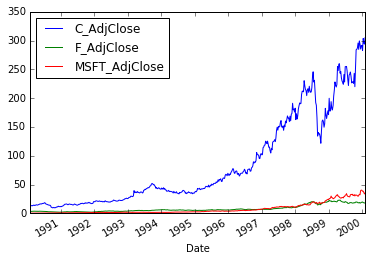

In [25]:
import matplotlib.pyplot as plt
import matplotlib.figure 
%matplotlib inline

plt.figure(num=1, figsize=(20, 20))
fullDataClean.plot(x='Date')